In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root (2 levels up)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/vlmd")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from utils.signal_generator import generate_synthetic_bold
from utils.decomp import run_decomposition_pipeline
from utils.plot.plot_base import set_mpl_style

In [9]:
def orthogonality_index(imfs):
    K = imfs.shape[0]
    oi = 0
    for i in range(K):
        for j in range(i + 1, K):
            oi += np.sum(imfs[i] * imfs[j])
    return np.abs(oi) / np.sum(imfs**2)

def spectral_overlap(imfs, fs=1.25):
    from scipy.signal import welch
    K = imfs.shape[0]
    f, _ = welch(imfs[0], fs=fs)
    psd_all = np.zeros((K, len(f)))
    for k in range(K):
        f, Pxx = welch(imfs[k], fs=fs)
        psd_all[k, :] = Pxx / np.max(Pxx)
    overlap = np.sum(np.tril(np.corrcoef(psd_all))**2) / (K*(K-1)/2)
    return overlap

def mean_mutual_information(imfs):
    from sklearn.metrics import mutual_info_score
    K = imfs.shape[0]
    mi_total = 0
    for i in range(K):
        for j in range(i + 1, K):
            H, _, _ = np.histogram2d(imfs[i], imfs[j], bins=50)
            mi_total += mutual_info_score(None, None, contingency=H)
    return mi_total / (K * (K - 1) / 2)

In [ ]:
# Parameters
# local_alphas = [1500, 1800, 2000, 2200]
# local_latents = [48, 64, 96, 112, 128, 144]
# n_modes_list = [6, 8, 10, 12]
# fs = 1.25

# # Load existing results if available
# save_path = "vlmd_parameter_tuning_results.csv"
# if os.path.exists(save_path):
#     df_local = pd.read_csv(save_path)
#     print(f"Loaded {len(df_local)} previous results.")
# else:
#     df_local = pd.DataFrame(columns=[
#         "alpha", "n_latents", "n_modes",
#         "rec_error", "freq_mape", "runtime", "OI", "SOI", "MI"
#     ])
#     print("No previous results found — starting fresh.")

# results_local = []

# # Loop
# for alpha in local_alphas:
#     for n_latents in local_latents:
#         for K in n_modes_list:
#             # Check if already exists in df_local
#             if ((df_local["alpha"] == alpha) &
#                 (df_local["n_latents"] == n_latents) &
#                 (df_local["n_modes"] == K)).any():
#                 print(f"Skipping α={alpha}, L={n_latents}, K={K} (already done).")
#                 continue  # Skip existing config

#             print(f"\n Running VLMD with K={K}, α={alpha}, L={n_latents}...")
#             t0 = time.time()

#             # Generate and run model
#             X, gt = generate_synthetic_bold(
#                 n_channels=434,
#                 n_timepoints=488,
#                 n_modes=K,
#                 fs=fs,
#                 freq_range=(0.005, 0.25),
#                 noise_level=0.05,
#                 random_state=42,
#             )

#             vlmd_imfs, vlmd_freqs = run_decomposition_pipeline(
#                 X, method="vlmd", n_modes=K, fs=fs,
#                 alpha=alpha, num_latents=n_latents
#             )

#             # Compute metrics
#             X_recon = np.sum(vlmd_imfs, axis=0).T
#             rec_err = np.linalg.norm(X - X_recon) / np.linalg.norm(X)

#             f_true = gt["freqs"][:K]
#             f_est = np.array(vlmd_freqs)
#             freq_mape = np.mean(np.abs((f_true - f_est) / f_true)) if len(f_true) == len(f_est) else np.nan

#             elapsed = time.time() - t0

#             imfs = vlmd_imfs[:, :, 0]
#             OI = orthogonality_index(imfs)
#             SOI = spectral_overlap(imfs, fs=fs)
#             MI = mean_mutual_information(imfs)

#             # Store
#             result = {
#                 "alpha": alpha,
#                 "n_latents": n_latents,
#                 "n_modes": K,
#                 "rec_error": rec_err,
#                 "freq_mape": freq_mape,
#                 "runtime": elapsed,
#                 "OI": OI,
#                 "SOI": SOI,
#                 "MI": MI
#             }

#             # Append to both memory and dataframe
#             results_local.append(result)
#             df_local = pd.concat([df_local, pd.DataFrame([result])], ignore_index=True)

#             # Save incrementally
#             df_local.to_csv(save_path, index=False)
#             print(f"Saved new result α={alpha}, L={n_latents}, K={K}")

# print("\nAll runs complete. Total results:", len(df_local))


In [12]:
df_local = pd.read_csv("vlmd_parameter_tuning_results.csv")

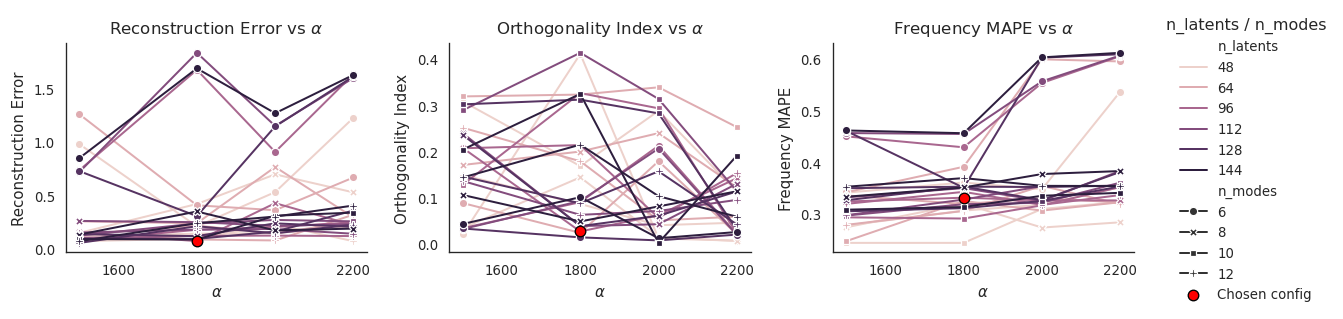

In [ ]:
# --- style FIRST ---
sns.set_theme(context="paper", style="white", font_scale=1.0)
set_mpl_style()

metrics = [
    ("rec_error", "Reconstruction Error"),
    ("OI",        "Orthogonality Index"),
    ("freq_mape", "Frequency MAPE"),
]

# double-column friendly size (good for Overleaf figure*)
fig, axes = plt.subplots(1, 3, figsize=(10.8, 2.6), sharex=True)

best = df_local[(df_local.alpha == 1800) &
                (df_local.n_modes == 8) &
                (df_local.n_latents == 96)]

for ax, (m, label) in zip(axes, metrics):
    sns.lineplot(
        data=df_local, x="alpha", y=m,
        hue="n_latents", style="n_modes",
        markers=True, dashes=False,
        ax=ax
    )

    ax.scatter(
        best["alpha"], best[m],
        color="red", edgecolor="black",
        s=40, zorder=10, label="Chosen config"
    )

    ax.set_title(f"{label} vs $\\alpha$")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel(label)
    ax.legend_.remove()  # remove per-axis legends

# Build ONE legend for the whole figure (includes hue/style + chosen config)
handles, labels = axes[0].get_legend_handles_labels()
# Ensure "Chosen config" is included only once (it may appear in each axis otherwise)
uniq = dict(zip(labels, handles))
fig.legend(
    uniq.values(), uniq.keys(),
    loc="center left", bbox_to_anchor=(0.9, 0.5),
    frameon=False, title="n_latents / n_modes"
)

fig.tight_layout(rect=(0, 0, 0.9, 1))  
sns.despine(fig=fig)
fig.savefig("vlmd_parameter_tuning_3panel.pdf", bbox_inches="tight")
plt.show()
